# ANR Time-Us - Analyses de données textuelles sous Python

Anaïs Chambat, ENS de Lyon - Master 2 Humanités Numériques

Ce notebook peut être utilisé en tant que concordancier mais aussi pour réaliser des premières analyses de données textuelles sous Python en complément des fonctionnalités proposées par TXM et IRaMuTeQ. Il a été réalisé à partir du cours de fouille de données de Julien Velcin (ERIC, Université Lyon 2) ainsi que des tutoriels et documentations des librairies utilisées.

## 1) Préalable

### A. Chargement des packages et des librairies nécessaires

In [1]:
#divers
import os #permet d'assigner un répertoire de travail
import math #utile pour réaliser des opérations mathématiques

import pandas as pd #gestion des tableaux
import numpy as np #gestion des tableaux
from lxml import etree #gestion des fichiers XML

In [2]:
#analyse textuelle et machine learning
from nltk.corpus import stopwords #suppression des mots-outils
import re #gestion des expressions régulières

from sklearn.feature_extraction.text import CountVectorizer #décompte d'occurrences
from sklearn.feature_extraction.text import TfidfVectorizer #décompte suivant le degré de rareté des mots
from sklearn.manifold import TSNE #technique de projection qui vise à conserver le voisinage des mots

In [3]:
#graphiques
from wordcloud import WordCloud #nuages de mots
import random #permet de fixer la composition de la figure
import matplotlib.pyplot as plt #graphiques simples
from bokeh.plotting import figure, show #graphiques dynamiques
from bokeh.models import LabelSet, Label, ColumnDataSource
from pyvis.network import Network #visualisations en réseaux dynamiques

### B. Préparation des données

On charge un fichier de mots-outils: il a été enrichi au fur et à mesure des tests à partir ceux contenus dans la librairie nltk. Son format texte permet de l'editer à tout moment et de rajouter d'autres mots-clés à retirer de l'analyse qui seraient spécifique au contexte du projet Time-Us.

In [4]:
with open("sw_fr.txt","r", encoding='utf8') as f:
    sw = [line.strip() for line in f.readlines()]
print(sw[0:10]) #sw = stop-words

['à', 'abord', 'absolument', 'actuellement', 'ainsi', 'alors', 'apparemment', 'approximativement', 'après', 'après-demain']


Il s'agit ensuite d'instancier le corpus à étudier.

In [5]:
with open("TimeUsCorpus/presse_La-tribune-lyonnaise.txt","r", encoding='utf8') as f:
    lines = [line.strip() for line in f.readlines()] #on segmente le texte en plusieurs unités textuelles
p_corpus = lines[0:1170] #on assigne le contenu obtenu dans un objet
print(p_corpus[0:7])

['CONSEIL DES PRUD’HOMMES.', '26 février 1845.', 'Roche, fabricant, C. Godemard , propriétaire.', 'La convention que fait un ouvrier avec un propriétaire , par laquelle il consent l’inscription sur son livret de la somme par lui due pour arrérages de loyer et s’engage à payer par la retenue du huitième de ses façons est-elle légale ? — Non.', "Le Conseil des prud'hommes auquel l’exécution de cette convention est soumise, a-t-il le droit de la déclarer illicite et par suite de l'annuler ? — Oui.", "Les parties avaient fait par acte sous seing-privé une convention par laquelle Godemard était autorisé à faire une retenue du huitième des façons de Roche, chef d’atelier, débiteur d’arrérages de loyer jusqu’à parfait payement. Roche a exécuté cette convention pendant longtemps, mais il en demande aujourd'hui l’annulation à raison de l’état de gêne où il se trouve. Le conseil a jugé que la convention n’était pas légale et en a prononcé la nullité.", "Nous voyons avec plaisir dans cette cause 

## 2) Etude des concordances de mots

Si on souhaite trouver toutes les occurrences, on peut afficher ce qu'on appelle un concordancier. Il s'agit d'une liste triée alphabétiquement des principaux mots employés dans un corpus, précisant chaque instance des mots accompagnée de leur contexte immédiat. 

In [6]:
#on travaille ici sur un corpus complet (c_corpus), non segmenté en unités textuelles (p_corpus)
c_corpus = ""
with open("TimeUsCorpus/presse_La-tribune-lyonnaise.txt", "r", encoding='utf8') as file:
    c_corpus = c_corpus.join(line.rstrip("\n") + " " for line in file.readlines())

In [7]:
#définition de la fonction "concord"
window = 50 #permet d'ajuster le contenu textuel affiché dans la console

def concord(c_corpus, pat):
    pattern = re.compile(pat)
    result = pattern.finditer(c_corpus)
    pos_pattern = [m.span() for m in result]
    context_left = pd.DataFrame([c_corpus[i-window:i-1] for (i, j) in pos_pattern])
    center = pd.DataFrame([c_corpus[i: j] for (i, j) in pos_pattern])
    context_right = pd.DataFrame([c_corpus[j+1:j+window] for (i, j) in pos_pattern])
    return (pd.concat([context_left, center, context_right], axis=1))
#m: motif recherché
#i: début du motif
#j: fin du motif

L'utilisation d'une barre verticale "|" permet d'assigner d'autres termes à la requête en cours.

In [8]:
#afficher le nombre d'occurences grâce à la fonction len()
len(concord(c_corpus, "Audience|audience"))

259

Il peut être utile de distinguer l'usage du pluriel ou du singulier des occurrences à rechercher.

In [9]:
#afficher les résultats de la requête
concord(c_corpus, "audiences")

0          0  \
0   e de ne pas se borner au compte-rendu des grandes  audiences   
1    fondation de L'Echo de la Fabrique ; les petites  audiences   
2   ivant l’usage du conseil. On voit que ces petites  audiences   
3   nt d’être explorées. Conseil des Prud'hommes. Les  audiences   
4   nté aucune cause à citer. Par contre, les petites  audiences   
5   e compte-rendu exact et complet de quatre grandes  audiences   
6   audiences de chaque mois et de celles des petites  audiences   
7   s petites audiences. Conseil des Prud'hommes. Les  audiences   
8   égard aux chefs d’atelier que le compte-rendu des  audiences   
9   ard. (V. ci-dessus audience du 30 septembre.) Les  audiences   
10   importante à citer. CONSEIL DES PRUD'HOMMES. Les  audiences   
11   ouvriers en payement de huitaine ont eu lieu aux  audiences   
12  ent rendus à leur propriétaire. observations.—Les  audiences   
13  ouvriers. Il a fallu à Dubuis comparaître à trois  audiences   
14  débiteur. C’est ce qui est arrivé dans toutes les  audiences   
15  contre Couturier et deux autres. Nota. Toutes ces  audiences   

                                                    0  
0   du mercredi, ainsi que nous l’avons fait jusqu’à   
1   des lundi et vendredi présentent bien souvent bea  
2   méritent d’être explorées. Conseil des Prud'homme  
3   des 2 et 9 juillet n’ont présenté aucune cause à   
4   ont été assez chargées. Dans celle du vendredi 4,  
5   de chaque mois et de celles des petites audiences  
6    Conseil des Prud'hommes. Les audiences des 3,10   
7   des 3,10 et 17 septembre n’ont présenté aucune ca  
8   du conseil des prud'hommes ne peut atteindre son   
9   des 21 et 28 octobre n’ont présenté rien de vraim  
10  des 30 décembre et 6 janvier n’ont présenté aucun  
11  des 24 et 25 janvier ; elles ont été renvoyées à   
12  du conseil ont toujours lieu en présence d’un aud  
13  pour obtenir le remboursement d’une somme de huit  
14  depuis la reprise des séances du conseil, et nota  
15  ont été remplies, par des résiliations d’apprenti

Il est possible de formuler des requêtes en langage naturel avec des apostrophes, des espaces, des accents et des majuscules. 

In [10]:
#concord(c_corpus, "conseil des prud'hommes|CONSEIL DES PRUD'HOMMES")
len(concord(c_corpus, "conseil des prud'hommes|CONSEIL DES PRUD'HOMMES"))

29

In [11]:
len(concord(c_corpus, "négociant"))

170

In [12]:
concord(c_corpus, "ouvrière")

0         0  \
0    mis des notes désobligeantes sur le livret d’une  ouvrière   
1   réflexion à l’usage de nos confrères de la presse  ouvrière   
2   livrance du livret doit équivaloir pour la classe  ouvrière   
3   a rédaction duquel des représentants de la classe  ouvrière   
4   remarquons avec peine que les droits de la classe  ouvrière   
5   la jeune Favier. Le chef d'atelier qui occupe une  ouvrière   
6   s, soit dans l’atelier, soit eu la possession des  ouvrière   
7    l'inconduite de Frédière, qui aurait dérangé ses  ouvrière   
8   nfier la fabrication d’une pièce d’écharpes à une  ouvrière   
9   rpes à une ouvrière , pour la tisser en qualité d  ouvrière   
10  sera de 45 centimens. La demoiselle fdorel, jeune  ouvrière   
11  mille et par conséquent d’exclure les ouvriers et  ouvrière   
12  rétend que la demoiselle Mathon a travaillé comme  ouvrière   
13  éboutée de cette prétention , et sera payée comme  ouvrière   
14   entre Favol et Guyot. Audience du 29 novembre. L  ouvrière   
15  SEIL DES PRUD HOMMES. Audience du 21 mars 1849. L  ouvrière   
16  provisoire, voulant venir au secours de la classe  ouvrière   

                                                    0  
0   a été condamné à lui faire avoir un autre livret   
1   parisienne. On publie chaque année les statistiqu  
2   à la patente, surtout le fils ayant un domicile s  
3   seront appelés, vienne réglementer l’industrie et  
4   sont toujours de plus en plus froissés par ces ch  
5   , sans se faire remettre le livret, dont elle doi  
6   , seraient rendus à leur propriétaire. observatio  
7   , et offrait de rendre l’atelier contre les somme  
8   , pour la tisser en qualité d’ouvrière à métier,   
9   à métier, dans l’atelier qu’elle jugerait lui con  
10  , vient former la même demande contre Gagnin, che  
11   qui n’avaient pas les mêmes charges, comment se   
12   tandis que la demoiselle Mathon soutient le cont  
13   Un nommé Giroud faisant appeler Mantel et Mil- l  
14  devideuse qui quitte l’atelier au moment où ses s  
15  dévideuse à gages doil-ellle finir l’année commen  
16  , fit une commande d'écharpes et de drapeaux , et

In [13]:
concord(c_corpus, "mademoiselle|demoiselle")

0             0  \
0   ne indemnité? — Non. Ainsi jugé entre Fatisson et    demoiselle   
1   — Non. Ainsi jugé au profit de dame Feriol contre    demoiselle   
2   il s’agit d'argent prêté? — Non. Ainsi jugé entre    demoiselle   
3   e sans indemnités?oui. Ainsi jugé entre Cazaux et    demoiselle   
4   rofit de Rillieux contre Vincent, qui occupait la    demoiselle   
5    14 avril. Carnet, chef d'atelier, prétend que la    demoiselle   
6   légations de Camet il a été condamné à payer à la    demoiselle   
7    façons dues aux ouvriers? — Oui. Ainsi jugé pour    demoiselle   
8   ndemnité ? Oui. Ainsi jugé entre veuve Favier, et    demoiselle   
9   sommes pour lesquelles il n’avait aucun titre, et    demoiselle   
10   intégralement payé par le liquidateur ? Oui. Les    demoiselle   
11  été décidé que la somme de 70 francs revenait aux    demoiselle   
12  l'inscription de cette dette, vu le serment de la    demoiselle   
13  l pas? Pourquoi le serment a-t-il été déféré à la    demoiselle   
14  telier qu’elle jugerait lui convenir? — Oui... La    demoiselle   
15  é l’arbitrage portant que faute par Baudran et la    demoiselle   
16  nt levée pur l’ourdisseuse du négociant et que la    demoiselle   
17  que la part de l’ouvrier sera de 45 centimens. La    demoiselle   
18  ient à ce dernier de n’en pas profiter? — Oui. La    demoiselle   
19  on s’étant remplacé immédiatement, a voulu que la    demoiselle   
20  and et Dauphin. La seconde affaire était entre la    demoiselle   
21  ée à quinzaine. La seconde affaire était entre la    demoiselle   
22  et le citoyen Cardinal. Ce dernier prétend que la    demoiselle   
23   Mathon a travaillé comme ouvrière, tandis que la    demoiselle   
24  fr. que Duranton avait marqué sur le livret de la    demoiselle   
25  ndemnité annuelle stipulée? Oui. Ainsi jugé entre    demoiselle   
26  pulée? Oui. Ainsi jugé entre demoiselle Lacour et    demoiselle   
27   diminution sur son gage? — oui. Ainsi jugé entre    demoiselle   
28  tant des mois échus? — Oui. Ainsi décidé entre la    demoiselle   
29  , quitte l’aie- lier ? — Oui. Ainsi jugé entre la    demoiselle   
30   Charnier, Grangcr et Morel, une affaire entre la    demoiselle   
31  orel, une affaire entre la demoiselle Petit et la    demoiselle   
32  tre restreinte au 8e ? — Oui. Ainsi jugé entre la    demoiselle   
33   peuvent-ils être repris? — Non. Ainsi jugé entre    demoiselle   
34  communauté a profité ? — Oui. Ainsi jugé pour les    demoiselle   
35  n. Ainsi jugé pour Creuzet contre Robert. Affaire    demoiselle   
36  ers , l’une des plaies de la fabrique de Lyon. La    demoiselle   
37  ant la révolution de Février était arrivée, et la    demoiselle   
38  çu et on a interdit la parole au mandataire de la    demoiselle   
39  it-il au moins qu’il y eut impartialité, et si la    demoiselle   
40  nt rendu, en cette audience, dans l'affaire de la    demoiselle   
41   dames Qnt été condamnées à payer 150 francs à la    demoiselle   
42  u 18 décembre 1850. Dlle Fayet contre Vincent. La    demoiselle   
43  u, après deux invitations, le conseil autorise la    demoiselle   
44  testation, Vincent sera cité à la diligence de la    demoiselle   
45  demoiselle Favel. Dlle Ferlay contre Dobtaire. La    demoiselle   
46   Elle y est demeurée 5 mois, logée et nourrie. La    demoiselle   
47   paraîtrait qu'après quelques jours d’absence, la    demoiselle   
48  et ses maîtres, discussion à la suite de laquelle  mademoiselle   
49   plaignant du peu de régularité de la conduite de  mademoiselle   
50  la cause, et attendu la retraite volontaire de la    demoiselle   
51  bales d’apprentissage sont résiliées; condamne la    demoiselle   

                                                    0  
0   Desche- lette. Le conseil a-t-il le droit d’exige  
1   Dumas; néanmoins l'indemnité à été réduite à 80 f  
2   Ruffet et Muriaux. Plusieurs causes pour indemnit  
3   Barlet, cette dernière a reçu, à cet égard, une r  
4   Arno

## 3) Distribution des mots les plus fréquents

Dans la section qui suit, nous allons étudier la distribution des mots les plus fréquents. Nous avons besoin pour cela d'utiliser un corpus segmenté en unités textuelles, ici les paragraphes. Sinon, l'analyse tokénise d'elle-même le corpus. Dès lors qu'il y aura un élément de ponctuation, les logiciels d'analyse textuelles (TXM, IRaMuTeQ) considérent qu'il s'agit d'une nouvelle unité. Vous perdrez alors toute prise sur la construction du corpus à moins de le spécifier pour chaque requête que vous effectuerez.

### A. Construction d'une matrice des paragraphes

Nous commençons par contruire une matrice à partir des paragraphes du corpus. Il convient de spécifier uniquement le corps de texte auquel cas le paragraphe d'introduction au projet serait également comptabilisé dans les analyses. 

In [14]:
tf_vectorizer = CountVectorizer(stop_words=sw)
tf_vectorizer.fit(p_corpus)
X = tf_vectorizer.transform(p_corpus)
features = tf_vectorizer.get_feature_names()

(num_doc, num_f) = X.shape
print(X[0:1])

#tf: occurrences
#X: matrice de x dimensions
#features: unités textuelles composant le vocabulaire du corpus

  (0, 930)	1
  (0, 1994)	1
  (0, 3176)	1


In [15]:
# les "labels" du nuage sont les mots
cloud_labels = features
# les poids correspondent à la somme des TF selon les lignes de la matrice
cloud_weights = np.ravel(np.sum(X, axis=0))
# on construit un dictionnaire qui associe chaque label (mot) au poids correspondant (TF total)
dictionary = dict(zip(cloud_labels, cloud_weights))
# on trie par ordre décroissant
sorted_by_value = sorted(dictionary.items(), key=lambda kv: kv[1], reverse=True)

print(sorted_by_value[0:20])

[('atelier', 322), ('conseil', 312), ('chef', 268), ('audience', 243), ('contre', 210), ('jugé', 173), ('cette', 167), ('ouvrier', 155), ('indemnité', 144), ('négociant', 120), ('prix', 115), ('fr', 108), ('ont', 108), ('prud', 99), ('payer', 96), ('livret', 95), ('faire', 92), ('hommes', 92), ('cause', 88), ('apprentissage', 83)]


### B. Représentations graphiques

* Loi de Zipf

Il s'agit d'une observation empirique de la distribution des mots dans un texte. Elle représente la fréquence d'occurrence d'un mot suivant son rang.

In [16]:
#on assigne le dictionnaire obtenu précédemment dans un JDD
df = pd.DataFrame(sorted_by_value) 
print(df[0:20])
len(df)

                0    1
0         atelier  322
1         conseil  312
2            chef  268
3        audience  243
4          contre  210
5            jugé  173
6           cette  167
7         ouvrier  155
8       indemnité  144
9       négociant  120
10           prix  115
11             fr  108
12            ont  108
13           prud   99
14          payer   96
15         livret   95
16          faire   92
17         hommes   92
18          cause   88
19  apprentissage   83


4397

Text(0.5, 0, 'Mots')

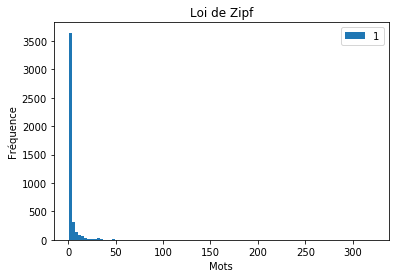

In [17]:
#on représente la série par un histogramme
g = df.plot.hist(bins = 100)
g.set_title("Loi de Zipf")
g.set_ylabel("Fréquence")
g.set_xlabel("Mots")

Elle témoigne ici d'un corpus au vocabulaire varié contenant de nombreux hapax.

* Nuage de mots les plus fréquents (syntagmes signifiants)

In [18]:
#initialisation du nuage de mots à partir du dictionnaire précédemment crée
limit = 30
bgcolor = '#000000'
    
wordcloud = WordCloud(
    max_words=limit,
    background_color=bgcolor,
).fit_words(dictionary)

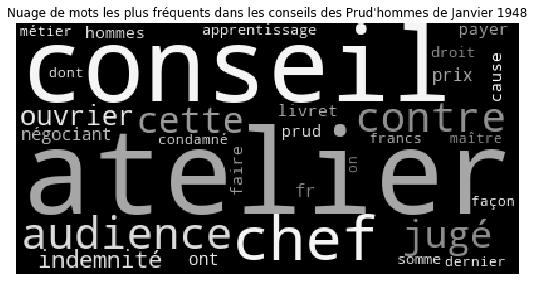

In [19]:
#appel de la librairie "matplotlib" pour pouvoir afficher le nuage dans la console
%matplotlib inline 

fig = plt.figure()
fig.set_figwidth(9) #fixe la largeur de la figure
fig.set_figheight(9) #fixe la hauteur

def grey_color(word, font_size, position, orientation, random_state=None, **kwargs):
    return 'hsl(0, 0%%, %d%%)' % random.randint(50, 100)

plt.imshow(wordcloud.recolor(color_func=grey_color)) #en nuances de gris
plt.axis('off')
plt.title("Nuage de mots les plus fréquents dans les conseils des Prud'hommes de Janvier 1948", size=12)
plt.show()

### C. Projeter les données

#### Initialisation de la matrice

In [20]:
#on regarde à nouveau la taille de la matrice
X.shape

(1170, 4397)

In [21]:
#on choisit de se concentrer sur les mots les plus fréquents (>20)
t_freq = np.where(cloud_weights>20)
index = t_freq[0]
X_small = X[:,index]
features_small = np.array(features)[index]
print(X_small.shape)

(_,num_f_small) = X_small.shape

(1170, 129)


In [22]:
#il est possible d'en dresser un index
np.array(features)[index]

array(['50', 'affaire', 'apprenti', 'apprentissage', 'arbitrage',
       'arbitres', 'arrêt', 'atelier', 'attendu', 'aucune', 'audience',
       'aurait', 'avons', 'ayant', 'bertrand', 'brisson', 'cas', 'cause',
       'causes', 'celle', 'centimes', 'cet', 'cette', 'chef', 'chefs',
       'chez', 'compagnon', 'compte', 'condamné', 'conseil', 'contrat',
       'contravention', 'contre', 'convention', 'conventions',
       'créancier', 'demande', 'demoiselle', 'dernier', 'devant', 'dire',
       'dit', 'donner', 'dont', 'droit', 'due', 'débiteur', 'décision',
       'défaut', 'eux', 'fabricant', 'fabrication', 'fabrique', 'faire',
       'faite', 'façon', 'façons', 'fils', 'fr', 'frais', 'francs',
       'hommes', 'huitaine', 'indemnité', 'intérêt', 'intérêts', 'jours',
       'jugement', 'jugé', 'laquelle', 'lieu', 'livre', 'livret', 'loi',
       'lorsqu', 'lorsque', 'matières', 'maître', 'mm', 'mois', 'montage',
       'montant', 'métier', 'métiers', 'négociant', 'négociants', 'on',
 

#### Visualisation de la proximité de chaque balise "p"

On utilise ici une technique de projection en 2D qui cherche à conserver le voisinage des mots: la t-SNE (*t-distributed stochastic neighbor embedding*)

In [23]:
visu = TSNE(n_components=2, verbose=2, n_iter=1000, perplexity=40).fit_transform(X_small.toarray())

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1170 samples in 0.005s...
[t-SNE] Computed neighbors for 1170 samples in 0.306s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1170
[t-SNE] Computed conditional probabilities for sample 1170 / 1170
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 0.109s
[t-SNE] Iteration 50: error = 73.1878815, gradient norm = 0.2409244 (50 iterations in 0.630s)
[t-SNE] Iteration 100: error = 73.3818512, gradient norm = 0.2505035 (50 iterations in 0.593s)
[t-SNE] Iteration 150: error = 72.8717041, gradient norm = 0.2347394 (50 iterations in 0.616s)
[t-SNE] Iteration 200: error = 74.1339874, gradient norm = 0.2290350 (50 iterations in 0.667s)
[t-SNE] Iteration 250: error = 74.3015442, gradient norm = 0.1925537 (50 iterations in 0.657s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.301544
[t-SNE] Iteration 300: error = 1.2296039, gradient norm = 0.0034270 (50 iterations in 0.469s

In [24]:
visu[0:10]

array([[ 1.784472  , 20.372196  ],
       [-1.071157  , -1.3566633 ],
       [ 0.0761994 , -0.11613963],
       [ 4.2621384 , -0.17396145],
       [ 0.7658855 , 22.820332  ],
       [-6.00716   ,  7.3915014 ],
       [ 7.7205    , 11.018754  ],
       [ 1.77922   , 20.375097  ],
       [ 3.0046988 , 22.632467  ],
       [-2.351713  ,  4.467354  ]], dtype=float32)

Les coordonnées pour chaque document considéré sont ensuite projetées grâce à la librairie graphique dynamique "Bokeh".

In [25]:
vv = visu.transpose()

source_texte = ColumnDataSource(data=dict(x=vv[0], y=vv[1], doc_number= range(num_doc)))
labels = LabelSet(x='x', y='y', text='doc_number', level='glyph',
              x_offset=5, y_offset=5, source=source_texte, render_mode='canvas', text_font_size="5pt")

p = figure(title = "Projection des unités textuelles")

p.circle(vv[0], vv[1], fill_alpha=0.2, size=3)    
p.add_layout(labels)

show(p)

#### Visualisation de la proximité des mots

In [26]:
visu_mots = TSNE(n_components=2, verbose=2, n_iter=1000, perplexity=40).fit_transform(X_small.transpose().toarray())

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 129 samples in 0.000s...
[t-SNE] Computed neighbors for 129 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 129 / 129
[t-SNE] Mean sigma: 2.397207
[t-SNE] Computed conditional probabilities in 0.011s
[t-SNE] Iteration 50: error = 77.1398468, gradient norm = 0.3626342 (50 iterations in 0.070s)
[t-SNE] Iteration 100: error = 79.8925552, gradient norm = 0.3825320 (50 iterations in 0.076s)
[t-SNE] Iteration 150: error = 78.7832031, gradient norm = 0.4408054 (50 iterations in 0.059s)
[t-SNE] Iteration 200: error = 75.6319046, gradient norm = 0.4077009 (50 iterations in 0.055s)
[t-SNE] Iteration 250: error = 79.2273636, gradient norm = 0.3676357 (50 iterations in 0.034s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.227364
[t-SNE] Iteration 300: error = 1.1629015, gradient norm = 0.0037516 (50 iterations in 0.049s)
[t-SNE] Iteration 350: error = 1.0398616, gradient norm = 0.0015581 

In [27]:
visu_mots[0:10]

array([[ 1.2677274 , -1.3574625 ],
       [ 1.3163612 ,  0.85960764],
       [-0.8363294 , -1.2220087 ],
       [-1.1419818 , -1.0938001 ],
       [ 1.7932428 ,  0.41187108],
       [ 2.0036013 , -0.46317953],
       [ 0.98463225,  1.6417574 ],
       [ 4.9960327 , -2.0933228 ],
       [ 1.8788745 , -1.9916477 ],
       [ 1.6520796 ,  1.024713  ]], dtype=float32)

In [28]:
vv_mots = visu_mots.transpose()

source_texte_words = ColumnDataSource(data=dict(x=vv_mots[0], y=vv_mots[1], word_number=features_small))
labels = LabelSet(x='x', y='y', text='word_number', level='glyph',
              x_offset=5, y_offset=5, source=source_texte_words, render_mode='canvas', text_font_size="12pt")

p_mots = figure(title = "Projection des mots")

p_mots.circle(vv_mots[0], vv_mots[1], fill_alpha=0.2, size=3)    
p_mots.add_layout(labels)

show(p_mots)

Il s'agit enfin d'étudier la co-occurrence des mots (sont-ils souvent employés ensemble ?). Une manière "simple" consiste à multiplier la matrice de données par elle-même, ce qui revient à estimer une similarité entre les mots.

#### Visualisation en réseaux

In [29]:
# cf. https://pyvis.readthedocs.io/en/latest/tutorial.html#networkx-integration
co_occ = np.matmul(X_small.transpose().toarray(), X_small.toarray())

sources = [] #liste des mots sources
targets = [] #liste des mots cibles
weights = [] #score de co-occurrence entre la source et la cible
for i in range(num_f_small):
    for j in range(num_f_small):
        if ((i != j) & (co_occ[i, j] > 20)):
                sources = sources + [features_small[i]]
                targets = targets + [features_small[j]]
                weights = weights + [float(co_occ[i, j])]
                # float tranforme la valeur de co-occurrence en un nombre réel
                # (nécessaire sous certains environnements)

In [30]:
#on crée des séries de données au format "pandas"
sources = pd.Series(sources)
targets = pd.Series(targets)
weights = pd.Series(weights)

In [31]:
#fixer les paramètres d'affichage du graphe
got_net = Network(height="400px", width="100%", bgcolor="#222222", font_color="white", notebook=True)
got_net.barnes_hut()

#pour générer la table des liens
edge_data = zip(sources, targets, weights)

for e in edge_data:
    src = e[0]
    dst = e[1]
    w = e[2]
    got_net.add_node(src, src, title=src)
    got_net.add_node(dst, dst, title=dst)
    got_net.add_edge(src, dst, value=w)

neighbor_map = got_net.get_adj_list()

#pour générer la table des noeuds
for node in got_net.nodes:
    node["title"] += " Neighbors:<br>" + "<br>".join(neighbor_map[node["id"]])
    node["value"] = len(neighbor_map[node["id"]])

got_net.show_buttons(filter_=['physics'])    
    
got_net.show("co-occurrences.html")